# **Import Libraries**

In [1]:
# Standard library
import os
import shutil
import random
import glob
from pathlib import Path

# Third-party library
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, 
    RandomFlip, RandomRotation, RandomZoom, RandomContrast
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

# Konfigurasi Seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"TensorFlow Version: {tf.__version__}")

2026-01-28 01:51:07.456158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769565067.801309      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769565067.898255      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769565068.740407      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769565068.740461      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769565068.740464      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0


# **Dataset Preparation**

In [2]:
def setup_kaggle_dataset(input_root, target_split_dir, train_ratio=0.7, val_ratio=0.1):
    """
    Menyiapkan dataset dari /kaggle/input (read-only) ke /kaggle/working (writable)
    dengan struktur split train/val/test.
    """
    # 1. Cari folder dataset asli (biasanya 'Three_Classes' atau sejenisnya)
    # Kita cari secara otomatis agar fleksibel terhadap nama folder dataset di Kaggle
    search_path = os.path.join(input_root, "**", "Three_Classes") # Sesuaikan 'Three_Classes' jika nama folder di dataset Kaggle berbeda
    found_dirs = glob.glob(search_path, recursive=True)
    
    if not found_dirs:
        # Fallback search jika nama folder 'Three Classes' (pakai spasi) atau struktur lain
        search_path = os.path.join(input_root, "**", "*lasse*") # Mencari folder yang mengandung 'lasse' (Classes)
        found_dirs = [d for d in glob.glob(search_path, recursive=True) if os.path.isdir(d) and "split" not in d]
    
    if not found_dirs:
        raise FileNotFoundError("Folder dataset sumber tidak ditemukan di /kaggle/input. Pastikan dataset sudah di-attach.")
    
    original_dataset_dir = found_dirs[0]
    print(f"Dataset sumber ditemukan di: {original_dataset_dir}")

    # 2. Siapkan direktori target di /kaggle/working
    if os.path.exists(target_split_dir):
        print(f"Direktori {target_split_dir} sudah ada. Melewati proses split (hapus manual jika ingin ulang).")
        return (
            os.path.join(target_split_dir, "train"),
            os.path.join(target_split_dir, "val"),
            os.path.join(target_split_dir, "test")
        )

    print(f"Membuat struktur data di {target_split_dir}...")
    train_dir = os.path.join(target_split_dir, "train")
    val_dir = os.path.join(target_split_dir, "val")
    test_dir = os.path.join(target_split_dir, "test")

    # 3. Split dan Copy File
    classes = os.listdir(original_dataset_dir)
    
    for class_name in classes:
        class_src_path = os.path.join(original_dataset_dir, class_name)
        if not os.path.isdir(class_src_path):
            continue
            
        # Buat folder kelas di target
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Ambil list gambar
        images = os.listdir(class_src_path)
        random.shuffle(images)

        # Hitung jumlah split
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        # Sisa masuk ke test (~0.2)

        train_images = images[:n_train]
        val_images = images[n_train:n_train+n_val]
        test_images = images[n_train+n_val:]

        # Copy file (ini memakan waktu sedikit, tapi diperlukan untuk logika folder fisik)
        print(f"Memproses kelas '{class_name}': {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
        
        for img in train_images:
            shutil.copy(os.path.join(class_src_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_src_path, img), os.path.join(val_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_src_path, img), os.path.join(test_dir, class_name, img))

    print("Persiapan dataset selesai.")
    return train_dir, val_dir, test_dir

# Eksekusi Setup
# Di Kaggle, semua dataset input ada di /kaggle/input
KAGGLE_INPUT_ROOT = "/kaggle/input" 
WORKING_DIR = "/kaggle/working/data_split"

train_dir, val_dir, test_dir = setup_kaggle_dataset(KAGGLE_INPUT_ROOT, WORKING_DIR)

Dataset sumber ditemukan di: /kaggle/input/tomatofruits/Three Classes
Membuat struktur data di /kaggle/working/data_split...
Memproses kelas 'Unripe': 560 train, 80 val, 160 test
Memproses kelas 'Reject': 560 train, 80 val, 160 test
Memproses kelas 'Ripe': 560 train, 80 val, 160 test
Persiapan dataset selesai.


# **Data Pipeline & Augmentation**

In [3]:
def create_datasets(train_path, val_path, test_path, img_size=(128, 128), batch_size=32):
    """Membuat tf.data.Dataset pipeline."""
    
    # Load Datasets
    train_ds = image_dataset_from_directory(
        train_path, image_size=img_size, batch_size=batch_size, shuffle=True
    )
    val_ds = image_dataset_from_directory(
        val_path, image_size=img_size, batch_size=batch_size, shuffle=False
    )
    test_ds = image_dataset_from_directory(
        test_path, image_size=img_size, batch_size=batch_size, shuffle=False
    )
    
    class_names = train_ds.class_names
    print(f"Label Kelas: {class_names}")

    # Layer Preprocessing (Rescaling & Augmentasi)
    rescale = Rescaling(1./255)
    augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.2),
    ])

    # Mapping function untuk optimasi
    def preprocess_train(x, y):
        x = rescale(x)
        x = augmentation(x, training=True)
        return x, y

    def preprocess_eval(x, y):
        x = rescale(x)
        return x, y

    # Optimasi performa (Cache & Prefetch)
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.map(preprocess_eval, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(preprocess_eval, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Inisialisasi Dataset
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dataset, val_dataset, test_dataset, class_names = create_datasets(
    train_dir, val_dir, test_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE
)

Found 1680 files belonging to 3 classes.


I0000 00:00:1769565101.612414      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 240 files belonging to 3 classes.
Found 480 files belonging to 3 classes.
Label Kelas: ['Reject', 'Ripe', 'Unripe']


# **CNN Model Architecture**

In [4]:
def build_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        # Convolutional Block 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Convolutional Block 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Dense Layers
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_model(input_shape=IMG_SIZE + (3,), num_classes=len(class_names))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [5]:
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


I0000 00:00:1769565109.700752     124 service.cc:152] XLA service 0x7a14640055d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769565109.700789     124 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769565110.105364     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


16/53 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3483 - loss: 1.1779

I0000 00:00:1769565113.429098     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.4542 - loss: 1.0196 - val_accuracy: 0.5833 - val_loss: 0.7720
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6456 - loss: 0.6744 - val_accuracy: 0.7792 - val_loss: 0.6083
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6968 - loss: 0.5701 - val_accuracy: 0.7375 - val_loss: 0.6274
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7221 - loss: 0.5540 - val_accuracy: 0.7333 - val_loss: 0.5851
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7368 - loss: 0.5232 - val_accuracy: 0.7375 - val_loss: 0.6197
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7452 - loss: 0.4959 - val_accuracy: 0.7542 - val_loss: 0.6045
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7944 - loss: 0.4247 - val_accuracy: 0.7958 - val_loss: 0.6212
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8075 - loss: 0.4197 - val_accuracy: 0.8167 - val_loss: 0

# **Evaluation & Visualization**

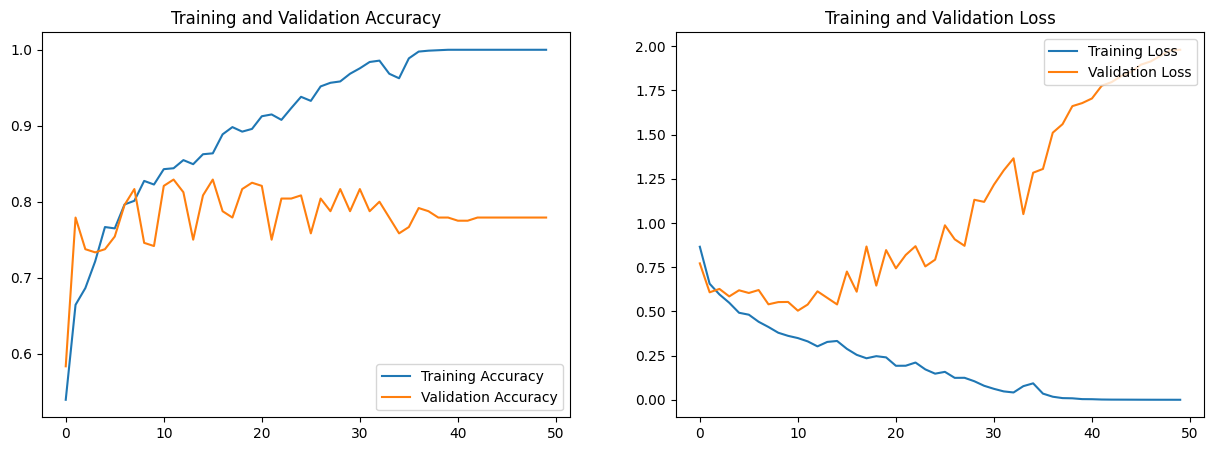


--- Evaluasi pada Data Train ---
              precision    recall  f1-score   support

      Reject       1.00      1.00      1.00       560
        Ripe       1.00      1.00      1.00       560
      Unripe       1.00      1.00      1.00       560

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680



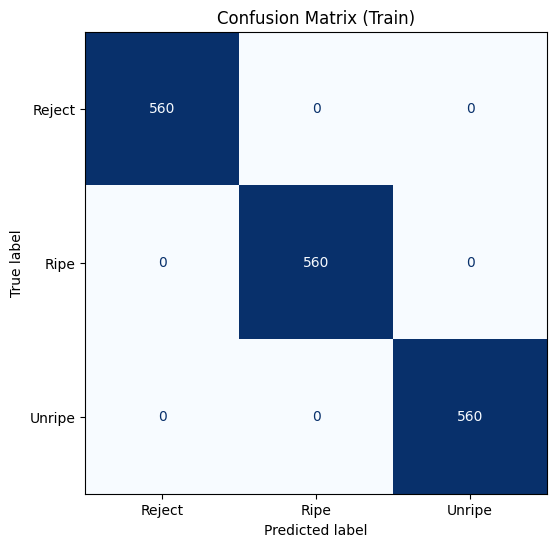


--- Evaluasi pada Data Validation ---
              precision    recall  f1-score   support

      Reject       0.67      0.71      0.69        80
        Ripe       0.77      0.71      0.74        80
      Unripe       0.90      0.91      0.91        80

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.78      0.78      0.78       240



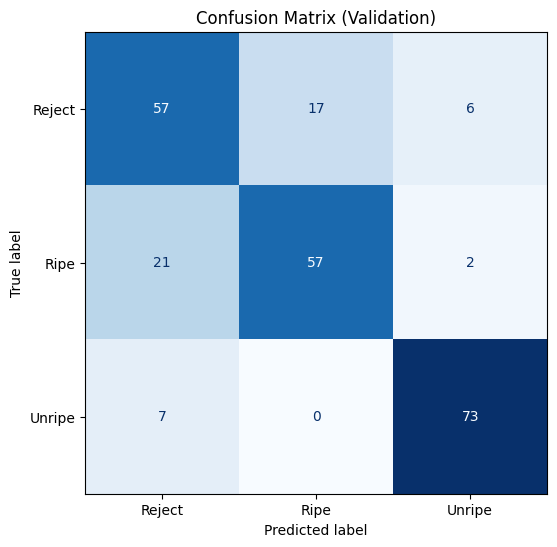

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7293 - loss: 3.0289

Final Test Accuracy: 78.96%

--- Evaluasi pada Data Test ---
              precision    recall  f1-score   support

      Reject       0.66      0.76      0.71       160
        Ripe       0.80      0.64      0.72       160
      Unripe       0.91      0.97      0.94       160

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



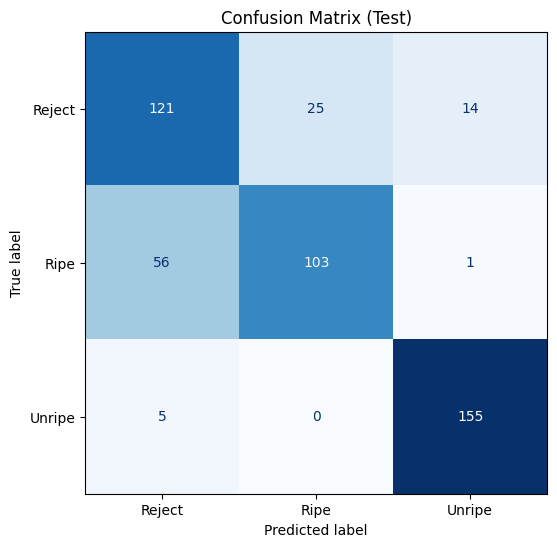

In [6]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def evaluate_performance(model, dataset, name, class_names):
    print(f"\n--- Evaluasi pada Data {name} ---")
    
    # Generate Prediksi
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        
    # Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix ({name})")
    plt.show()

# Tampilkan Hasil
plot_training_results(history)

# Evaluasi Train & Val
evaluate_performance(model, train_dataset, "Train", class_names)
evaluate_performance(model, val_dataset, "Validation", class_names)

# Evaluasi Final Test
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
evaluate_performance(model, test_dataset, "Test", class_names)

# **Save Model**

In [7]:
model_save_path = 'tomato_cnn_model.h5'
model.save(model_save_path)

print(f"Model berhasil disimpan di: {os.path.abspath(model_save_path)}")

# Cek ukuran file
file_size = os.path.getsize(model_save_path) / (1024 * 1024)
print(f"Ukuran Model: {file_size:.2f} MB")

Model berhasil disimpan di: /kaggle/working/tomato_cnn_model.h5
Ukuran Model: 37.87 MB
